In [15]:
import numpy as np
import tensorflow as tf

In [16]:
DATASET_DIR = '../Data/Stanford_Online_Products/'
FULL_DATASET_FILE = 'Ebay_info.txt'

In [17]:
class DataHandler:

    def __init__(self, dataset_dir,
                 split_dataset=0.2,
                 batch_size=16,
                 target_shape=(400, 400)):
        self.__target_shape = target_shape
        self.__dataset_dir = dataset_dir

        self.__dataset_partitions = split_dataset

        self.__train, self.__validation = self.__generate_dataset(batch_size=batch_size)

    def __generate_dataset(self, batch_size):
        data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                         width_shift_range=0.2,
                                                                         height_shift_range=0.2,
                                                                         shear_range=0.2,
                                                                         zoom_range=0.2,
                                                                         horizontal_flip=True,
                                                                         fill_mode='nearest',
                                                                         validation_split=self.__dataset_partitions)

        train = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                   target_size=self.__target_shape, color_mode='rgb',
                                                   batch_size=batch_size, shuffle=True, subset='training')

        validation = data_generator.flow_from_directory(self.__dataset_dir, class_mode="categorical",
                                                        target_size=self.__target_shape, color_mode='rgb',
                                                        batch_size=batch_size, subset='validation')

        return train, validation

    def get_train(self):
        return self.__train

    def get_validation(self):
        return self.__validation

    def get_shape(self):
        return self.__target_shape

In [18]:
data_handler = DataHandler(dataset_dir=DATASET_DIR, target_shape=(128, 128), batch_size=64)

train = data_handler.get_train()
validation = data_handler.get_validation()

Found 96047 images belonging to 12 classes.
Found 24006 images belonging to 12 classes.


In [19]:
type(train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

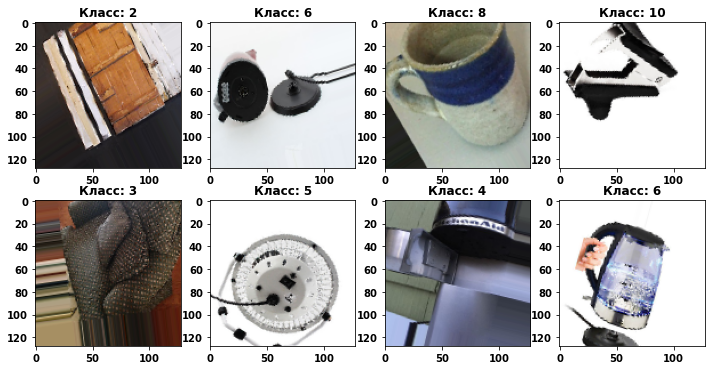

In [20]:
from matplotlib import pyplot as plt

first_batch = next(iter(train))

HEIGHT = 2
WIDTH = 4

fig, ax = plt.subplots(HEIGHT, WIDTH)
fig.set_figwidth(3 * WIDTH)
fig.set_figheight(3 * HEIGHT)
k = 0
for i in range(HEIGHT):
    for j in range(WIDTH):
        ax[i, j].set_title(f'Класс: {np.argmax(first_batch[1][k]) + 1}')
        ax[i, j].imshow(first_batch[0][k].astype(int))
        k += 1

Функция потерь

In [21]:
class TripletHardLoss(tf.keras.losses.Loss):

    def __init__(self, margin=0.5, squared=True):
        super().__init__()
        self.__margin = margin
        self.__squared = squared

    @tf.autograph.experimental.do_not_convert
    def call(self, y_true, y_pred):
        labels = tf.convert_to_tensor(y_true, name="labels")
        embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

        convert_to_float32 = (
                embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
        )
        precise_embeddings = (
            tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
        )

        batch_size = tf.shape(precise_embeddings)[0]
        adjacency_matrix = tf.matmul(labels, labels, transpose_b=True)
        adjacency_matrix = tf.cast(adjacency_matrix, tf.bool)
        negative_adjacency = tf.math.logical_not(adjacency_matrix)
        negative_adjacency = tf.cast(negative_adjacency, dtype=tf.dtypes.float32)
        positive_adjacency = tf.cast(adjacency_matrix, dtype=tf.dtypes.float32) - tf.eye(batch_size,
                                                                                         dtype=tf.float32)

        dist = self.__pairwise_distances(precise_embeddings)

        distance_embeddings = tf.reshape(dist, [batch_size, batch_size])

        hard_positives = self.__maximum_dist(distance_embeddings, positive_adjacency)
        hard_negatives = self.__minimum_dist(distance_embeddings, negative_adjacency)

        triplet_loss = tf.maximum(hard_positives - hard_negatives + self.__margin, 0.0)
        triplet_loss = tf.reduce_mean(triplet_loss)
        if convert_to_float32:
            return tf.cast(triplet_loss, embeddings.dtype)
        else:
            return triplet_loss

    def __minimum_dist(self, data, mask):
        axis_maximums = tf.math.reduce_max(data, 1, keepdims=True)

        masked_minimums = (
                tf.math.reduce_min(
                    tf.math.multiply(data - axis_maximums, mask), 1, keepdims=True
                )
                + axis_maximums
        )
        return masked_minimums

    def __maximum_dist(self, data, mask):

        masked_maximums = (
            tf.math.reduce_max(
                tf.math.multiply(data, mask), 1, keepdims=True
            )
        )

        return masked_maximums

    def __pairwise_distances(self, embeddings):
        """
        Рассчитать расстояние между векторами вложения
        Args:
                     embeddings: тензор в форме (batch_size, embed_dim)
        Returns:
                     piarwise_distances: тензор формы (batch_size, batch_size)
        """

        dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

        square_norm = tf.linalg.diag_part(dot_product)

        distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

        distances = tf.maximum(distances, 0.0)

        if not self.__squared:
            mask = tf.cast(tf.equal(distances, 0.0), tf.float32)
            distances = distances + mask * 1e-16

            distances = tf.sqrt(distances)

            distances = distances * (1.0 - mask)
        return distances


In [22]:
from tensorflow.keras.applications import resnet


class EmbeddingModel(tf.keras.Model):

    def __init__(self, target_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__base_cnn = resnet.ResNet50(
            weights="imagenet", input_shape=target_shape + (3,), include_top=False
        )

        trainable = False
        for layer in self.__base_cnn.layers:
            if layer.name == "conv5_block1_out":
                trainable = True
            layer.trainable = trainable

        self.__conv_1 = tf.keras.layers.Conv2D(128, kernel_size=(7, 7), padding='same', activation='relu')
        self.__pooling_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.__conv_2 = tf.keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu')
        self.__pooling_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.__flatten_1 = tf.keras.layers.Flatten()
        self.__dense_1 = tf.keras.layers.Dense(1024, activation="relu")
        self.__batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.__dense_2 = tf.keras.layers.Dense(512, activation="relu")
        self.__batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.__embedding = tf.keras.layers.Dense(256, kernel_regularizer='l2')

    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=None, mask=None):
        layer = self.__base_cnn(inputs)
        layer = self.__conv_1(layer)
        layer = self.__pooling_1(layer)
        layer = self.__conv_2(layer)
        layer = self.__pooling_2(layer)
        layer = self.__flatten_1(layer)
        #layer = self.__dense_1(layer)
        #layer = self.__batch_norm_1(layer)
        layer = self.__dense_2(layer)
        layer = self.__batch_norm_2(layer)
        layer = self.__embedding(layer)
        return layer

    def get_config(self):
        return {
            '__flatten_1': self.__flatten_1,
            '__dense_2': self.__dense_2,
            '__batch_norm_2': self.__batch_norm_2,
            '__embedding': self.__embedding,
            '__base_cnn': self.__base_cnn,
            '__dense_1': self.__dense_1,
            '__batch_norm_1': self.__batch_norm_1,
            '__conv_1': self.__conv_1,
            '__conv_2': self.__conv_2,
            '__pooling_1': self.__pooling_1,
            '__pooling_2': self.__pooling_2
        }

    def from_config(cls, config, custom_objects=None):
        return cls(**config)

In [23]:
embedding_model = EmbeddingModel(target_shape=data_handler.get_shape())
embedding_model.compile(optimizer='adam', loss=TripletHardLoss(margin=0.5))

In [ ]:
embedding_model.load_weights('Model/hard_model_v2')
embedding_model.fit(train, batch_size=128, validation_data=validation, epochs=5)


### Создание базы эмбеддингов

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [43]:
DATASET_DIR = '../Data/Stanford_Online_Products/'
FULL_DATASET_FILE = 'Ebay_train.txt'
TARGET_SHAPE = (128, 128)
SAVE_FILE = 'df_emb'
PATH_MODEL = 'Model/hard_model_v2'

In [47]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train = data_generator.flow_from_directory(DATASET_DIR, class_mode="categorical",
                                           target_size=TARGET_SHAPE, color_mode='rgb',
                                           batch_size=64, shuffle=False)

Found 120053 images belonging to 12 classes.


In [48]:
embedding_model = EmbeddingModel(target_shape=data_handler.get_shape())
embedding_model.load_weights('Model/hard_model_v2')
embeddings = embedding_model.predict(train)

In [51]:
full_embeddings = pd.DataFrame(data=embeddings)
full_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.021791,0.073511,0.099225,0.148314,0.203362,-0.323801,0.317262,-0.239847,-0.143200,-0.513478,...,-0.187918,-0.137461,0.267875,0.009518,-0.206974,0.120902,0.068765,0.050596,-0.185007,-0.448926
1,0.015554,0.061214,0.078124,0.114244,0.160304,-0.250355,0.240917,-0.188178,-0.114591,-0.397857,...,-0.147811,-0.110915,0.202073,0.007407,-0.161164,0.093235,0.054407,0.042065,-0.145890,-0.348348
2,0.019915,0.076801,0.102708,0.153000,0.211727,-0.333953,0.331590,-0.249770,-0.147768,-0.537257,...,-0.196467,-0.143270,0.279578,0.010120,-0.214272,0.126310,0.072759,0.051870,-0.193706,-0.469399
3,0.015000,0.110860,0.162073,0.244841,0.338889,-0.529417,0.574153,-0.402268,-0.224608,-0.891269,...,-0.320276,-0.219353,0.487538,0.014817,-0.343864,0.213984,0.128058,0.069724,-0.316767,-0.807159
4,0.018246,0.069421,0.100933,0.151805,0.203761,-0.326172,0.319307,-0.236923,-0.140393,-0.514340,...,-0.186798,-0.134169,0.271506,0.010883,-0.212830,0.119192,0.071295,0.047883,-0.183715,-0.459545


In [56]:
full_embeddings['path'] = train.filepaths
full_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,path
0,0.021791,0.073511,0.099225,0.148314,0.203362,-0.323801,0.317262,-0.239847,-0.143200,-0.513478,...,-0.137461,0.267875,0.009518,-0.206974,0.120902,0.068765,0.050596,-0.185007,-0.448926,../Data/Stanford_Online_Products/bicycle_final...
1,0.015554,0.061214,0.078124,0.114244,0.160304,-0.250355,0.240917,-0.188178,-0.114591,-0.397857,...,-0.110915,0.202073,0.007407,-0.161164,0.093235,0.054407,0.042065,-0.145890,-0.348348,../Data/Stanford_Online_Products/bicycle_final...
2,0.019915,0.076801,0.102708,0.153000,0.211727,-0.333953,0.331590,-0.249770,-0.147768,-0.537257,...,-0.143270,0.279578,0.010120,-0.214272,0.126310,0.072759,0.051870,-0.193706,-0.469399,../Data/Stanford_Online_Products/bicycle_final...
3,0.015000,0.110860,0.162073,0.244841,0.338889,-0.529417,0.574153,-0.402268,-0.224608,-0.891269,...,-0.219353,0.487538,0.014817,-0.343864,0.213984,0.128058,0.069724,-0.316767,-0.807159,../Data/Stanford_Online_Products/bicycle_final...
4,0.018246,0.069421,0.100933,0.151805,0.203761,-0.326172,0.319307,-0.236923,-0.140393,-0.514340,...,-0.134169,0.271506,0.010883,-0.212830,0.119192,0.071295,0.047883,-0.183715,-0.459545,../Data/Stanford_Online_Products/bicycle_final...


In [57]:
full_embeddings.to_csv('full_embeddings.csv')

In [99]:
import cv2
ANCHOR = '../Data/Stanford_Online_Products/bicycle_final/111085122871_2.JPG'
image = cv2.imread(ANCHOR)
image = cv2.resize(image, (128, 128))
image = np.reshape(image, (1, 128, 128, 3))
target_embedding = embedding_model.predict(image)

array([[ 2.27168035e-02,  7.27871880e-02,  9.60348174e-02,
         1.43762991e-01,  1.98777929e-01, -3.17050040e-01,
         3.10855895e-01, -2.35711306e-01, -1.41059369e-01,
        -5.02800167e-01, -1.76281154e-01,  2.18458414e-01,
         6.94123626e-01, -9.36852098e-02,  9.25124958e-02,
         1.79939032e-01, -1.64386153e-01, -1.55715808e-01,
         1.80441052e-01,  5.92536688e-01,  1.78605691e-01,
         4.36758362e-02,  6.02017902e-02,  2.13682413e-01,
         1.97784916e-01, -6.15918517e-01, -5.69194369e-02,
         1.78280786e-01,  6.78607076e-02,  1.32019371e-01,
        -8.49907380e-03, -2.30169427e-02,  2.78494328e-01,
         7.21877337e-01,  2.42311418e-01,  4.42817584e-02,
         3.75219464e-01,  1.33745760e-01, -2.83797860e-01,
        -5.78292370e-01,  2.69261390e-01, -1.39350444e-01,
         1.70134246e-01, -4.64886799e-02,  5.15882894e-02,
        -9.70123559e-02,  3.21168095e-01,  1.78038061e-01,
         2.22430959e-01, -1.78251535e-01, -1.64258778e-0

In [100]:
embeddings_diff = full_embeddings.iloc[:, :-1].values - target_embedding

In [101]:
df_distance = pd.DataFrame(data=np.sqrt(np.sum(np.square(embeddings_diff), axis=1)), columns=['Distance'])

In [102]:
df_distance['path'] = full_embeddings['path']
df_distance.head()

,Distance,path
0,0.084754,../Data/Stanford_Online_Products/bicycle_final...
1,0.849837,../Data/Stanford_Online_Products/bicycle_final...
2,0.259900,../Data/Stanford_Online_Products/bicycle_final...
3,3.092679,../Data/Stanford_Online_Products/bicycle_final...
4,0.111391,../Data/Stanford_Online_Products/bicycle_final...


In [103]:
top_images = df_distance.sort_values(by='Distance').iloc[:9, -1].values

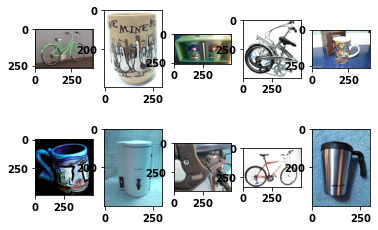

In [104]:
fig, ax = plt.subplots(2, 5)

k = 0
for i in range(2):
    for j in range(5):
        if k == 0:
            image = cv2.imread(ANCHOR)
            ax[0, 0].imshow(image)
            k += 1
            continue
        image = cv2.imread(top_images[k - 1])
        ax[i, j].imshow(image)
        k += 1

Первое изображение - anchor, остальные 9 предсказанные в порядке близости. Почему то он кучу кружек соотносит с
выбранным изображение велосипеда, но есть и пара велосипедов. (Возможно, что в predict всё же перемешался порядок,
поэтому стоит проверить и создать базу эмбеддингов, предсказывая по одному изображению, а не батчами, как сденлано
у меня)